# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

Your organization has asked you to explore and answer some questions from the data collected. See the project instructions.

In [75]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

drug_safety = pd.read_csv("drug_safety.csv")

In [76]:
drug_safety.head()

,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


---

## Two-sample proportions z-test:
Determine if the proportion of adverse effects differs significantly between the treatment group and control group. 

Null hypothesis:
The proportion of patients experiencing adverse effects is the same in the Drug and Placebo groups.
Alternative hypothesis:
The proportion of patients experiencing adverse effects is different between the Drug and Placebo groups.

In [77]:
adv_trx_count = drug_safety.groupby(['adverse_effects', 'trx']).count()['num_effects']
adv_trx_total = adv_trx_count.groupby('trx').sum()
# [drug_count, placebo_count]
yeses = [adv_trx_count['Yes']['Drug'], adv_trx_count['Yes']['Placebo']]
n = [adv_trx_total['Drug'], adv_trx_total['Placebo']]

two_sample_results = proportions_ztest(yeses, n)
two_sample_p_value = two_sample_results[1]
print(two_sample_p_value)

0.9639333330262475


The p-value was 0.964, which is greater than the significance level of 0.05.
Therefore, we fail to reject the null hypothesis and conclude that there is no significant difference in the proportion of adverse effects between the two groups.

----

## Chi-square Test of Independence:
Determine if the number of adverse effect is independent of the treatment and control group. 

Null Hypothesis: The number of adverse effects is independent of the treatment group.
Alternative Hypothesis: The number of adverse effects is not independent of the treatment group.

In [78]:
num_effects_groups = pingouin.chi2_independence(
    data=drug_safety,
    x="num_effects",
    y="trx"
)
num_effects_p_value = num_effects_groups[2]["pval"][0]
print(num_effects_p_value)

0.6150123339426765


The p-value was 0.615, which is greater than 0.05. Therefore, we fail to reject the null hypothesis and conclude that the number of adverse effects is independent of the treatment group.

----

## Visualization and Normal Distribution:
Examine if there is a significant difference between the ages of the Drug and Placebo groups. 

<AxesSubplot: xlabel='age', ylabel='Count'>

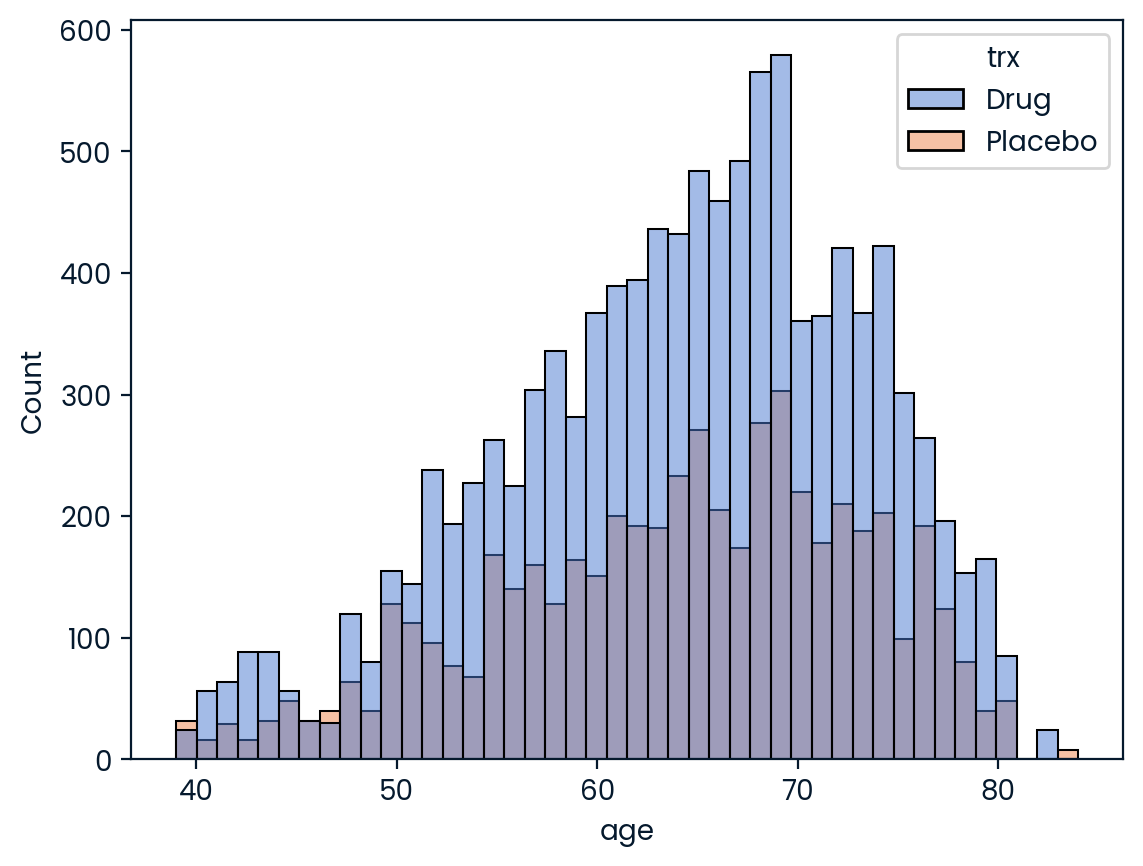

In [79]:
sns.histplot(data=drug_safety, x="age", hue="trx", palette = "muted", alpha = 0.5)

### Shapiro–Wilk Test

Null Hypothesis: The age distributions of the Drug and Placebo groups are the same.     
Alternative Hypothesis: The age distributions of the Drug and Placebo groups are different.

In [80]:
normality = pingouin.normality(
    data=drug_safety,
    dv='age',
    group='trx'
)
print(normality)

                W          pval  normal
trx                                    
Drug     0.976785  2.189152e-38   False
Placebo  0.975595  2.224950e-29   False


It does not follow a normal distribution.

In [81]:
age_trx = drug_safety.loc[drug_safety["trx"] == "Drug", "age"]
age_placebo = drug_safety.loc[drug_safety["trx"] == "Placebo", "age"]
age_group_effects = pingouin.mwu(age_trx, age_placebo)
age_group_effects_p_value = age_group_effects["p-val"]
print(age_group_effects_p_value)

MWU    0.256963
Name: p-val, dtype: float64


Since p = 0.257 > 0.05, we fail to reject the null hypothesis. There is no significant difference in age between the Drug and Placebo groups.